## Visualización de datos

Este notebook muestra como visualizar los datos 

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import locale

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

sns.set_context('talk')
locale.setlocale(locale.LC_TIME, "es")

'es'

In [39]:
dataFile = '../results/afp_chile_2020.csv'

dataDF = pd.read_csv(dataFile, parse_dates=['fecha'])
#dataDF.set_index('fecha', inplace=True)
dataDF.head()

,fecha,fondo,administradora,valor cuota,valor patrimonio
0,2020-01-01,A,CAPITAL,48914.38,4.075437e+12
1,2020-01-01,A,CUPRUM,51398.91,5.095773e+12
2,2020-01-01,A,HABITAT,52141.66,5.928281e+12
3,2020-01-01,A,MODELO,50732.63,1.202176e+12
4,2020-01-01,A,PLANVITAL,47650.90,4.987370e+11


In [40]:
dataDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3640 entries, 0 to 3639
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fecha             3640 non-null   datetime64[ns]
 1   fondo             3640 non-null   object        
 2   administradora    3640 non-null   object        
 3   valor cuota       3628 non-null   float64       
 4   valor patrimonio  3628 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 142.3+ KB


Graficamos los valores de cuota para la AFP Habitat

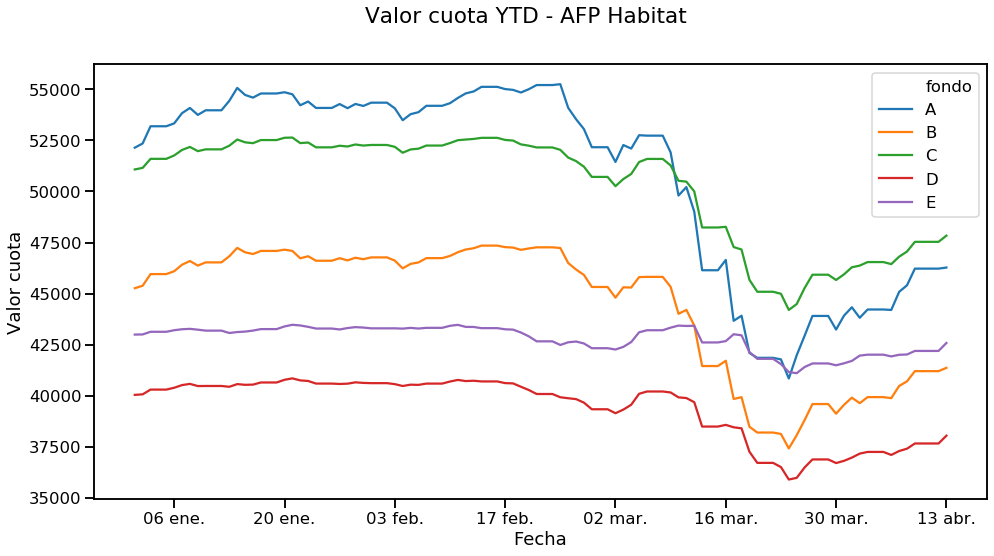

In [41]:
plotDF = dataDF[dataDF['administradora'] == 'HABITAT']

fig, ax = plt.subplots(figsize = (16,8))
sns.lineplot(x='fecha', y='valor cuota', hue='fondo',
             data=plotDF, ax=ax)

fig.suptitle('Valor cuota YTD - AFP Habitat', fontsize='large')
ax.set_xlabel('Fecha', fontsize='medium')
ax.set_ylabel('Valor cuota', fontsize='medium')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))

Calculamos y graficamos la variacione sporcentual desde el comienzo del año

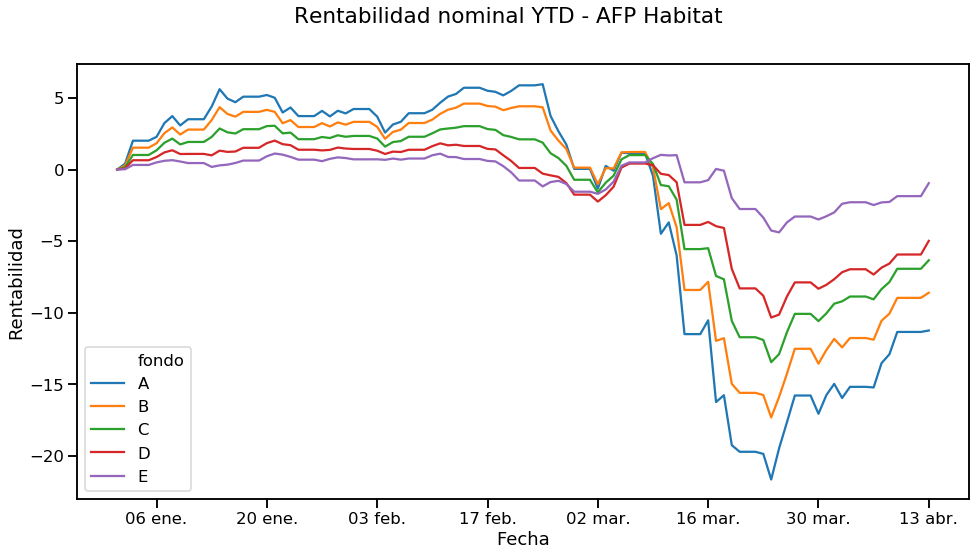

In [42]:
plotDF = dataDF[dataDF['administradora'] == 'HABITAT'].copy()

for name, group in plotDF.groupby('fondo'):
    #print(name)
    refValue = group.iloc[0]['valor cuota']
    plotDF.loc[group.index, 'variacion %'] = ((group['valor cuota'] - refValue)/refValue * 100)
    
#print(plotDF.head())
#plotDF['variacion %'] = ((plotDF['valor cuota'] - plotDF.loc[0, 'valor cuota'])/plotDF.loc[0, 'valor cuota'] * 100).values

fig, ax = plt.subplots(figsize = (16,8))
sns.lineplot(x='fecha', y='variacion %', hue='fondo',
             data=plotDF, ax=ax)

fig.suptitle('Rentabilidad nominal YTD - AFP Habitat', fontsize='large')
ax.set_xlabel('Fecha', fontsize='medium')
ax.set_ylabel('Rentabilidad', fontsize='medium')

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))